In [69]:
import yfinance as yf
import pandas as pd
import backtrader as bt
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
plt.rcParams["figure.figsize"] = [16,9]

In [70]:
data = yf.download("ETH-USD",interval="5m",start="2021-04-01",end="2021-04-14")
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2021-03-31 23:00:00+01:00,1934.445190,1938.509155,1934.445190,1938.509155,1938.509155,0
2021-03-31 23:05:00+01:00,1938.412476,1938.412476,1936.584961,1936.584961,1936.584961,11110400
2021-03-31 23:10:00+01:00,1935.968628,1935.968628,1935.027344,1935.027344,1935.027344,41912320
2021-03-31 23:15:00+01:00,1934.740601,1935.345825,1931.626343,1931.626343,1931.626343,11370496
2021-03-31 23:20:00+01:00,1930.901855,1932.533691,1930.689941,1932.533691,1932.533691,44593152


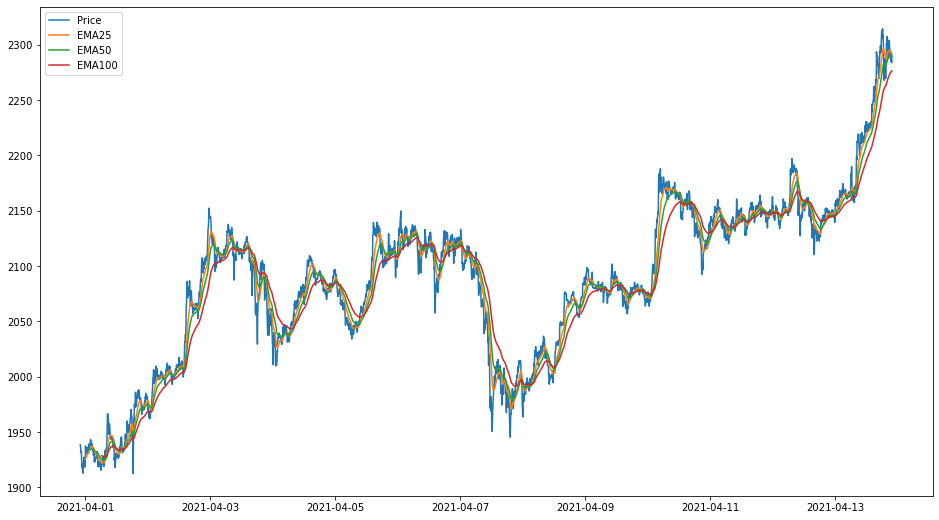

In [71]:
from ta.trend import EMAIndicator

data["EMA25"] = EMAIndicator(data["Close"],window=25).ema_indicator()
data["EMA50"] = EMAIndicator(data["Close"],window=50).ema_indicator()
data["EMA100"] = EMAIndicator(data["Close"],window=100).ema_indicator()

plt.plot(data["Close"],label="Price")
plt.plot(data["EMA25"],label="EMA25")
plt.plot(data["EMA50"],label="EMA50")
plt.plot(data["EMA100"],label="EMA100")
plt.legend()

In [72]:
def runOnce(data,emaFast,emaMiddle,emaSlow):
    
    data["EMA25"] = EMAIndicator(data["Close"],window=emaFast).ema_indicator()
    data["EMA50"] = EMAIndicator(data["Close"],window=emaMiddle).ema_indicator()
    data["EMA100"] = EMAIndicator(data["Close"],window=emaSlow).ema_indicator()

    startMoney = 40000
    money = startMoney
    nrStocks = 0
    portfolio = []
    wins = []

    waitForEntry = False

    stopLoss = 0
    takeProfit = 0
    boughtAt = 0

    def buy(crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt):
        # and today crossed EMA25 take buy position
        # stopLoss = EMA50, takeProfit = 1.5 * EMA50
        boughtAt = crntPrice
        howmany = int(money / crntPrice)
        cost = howmany * crntPrice 
        money -= cost
        nrStocks += howmany
        stopLoss = data["EMA50"][i]
        takeProfit = data["EMA50"][i] * 1.5
        print(i,"Long Buying %d positions at %.2f$, SL: %.2f$, TP: %.2f$"%(howmany,crntPrice,stopLoss,takeProfit))
        return crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt

    def sell(crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt):
        # sell
        value = crntPrice * nrStocks
        money += value
        win = value - (nrStocks * boughtAt)
        nrStocks = 0
        # just for safety
        boughtAt = 0
        stopLoss = 0
        takeProfit = 0
        return crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt, win


    for i,crntPrice in enumerate(data["Close"]):
        crntPrice = data["Close"][i]
        if i > 0:
            if nrStocks == 0:
                # if no positions yet
                if data["EMA25"][i] > data["EMA100"][i] and data["EMA25"][i] > data["EMA50"][i]:
                    crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt = buy(crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt)

            ## If we have positions just listen to exit 
            elif nrStocks > 0: # if we have long positions
                if crntPrice >= takeProfit:
                    crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt, win = sell(crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt)
                    print(i,"Long Sell TP, Profit: %.2f$, crntHolding: %.2f$"%(win,money))
                    wins.append(win)

                elif crntPrice <= stopLoss:
                    crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt, win = sell(crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt)
                    print(i,"Long Sell SL, Loss: %.2f$, crntHolding: %.2f$"%(win,money))         
                    wins.append(win)
                # also stop if lines start to cross
                # signal line cross
                emacross = 0
                if data["EMA25"][i-1] > data["EMA100"][i-1] and data["EMA25"][i] <= data["EMA100"][i]:
                    emacross = -1

                if emacross == -1: 
                    crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt, win = sell(crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt)
                    print(i,"Long Sell EMAcross, Loss: %.2f$, crntHolding: %.2f$"%(win,money))
                    wins.append(win)
            elif nrStocks < 0: # if we have short positions
                pass

        # keep track of portfolio value
        portValue = money + (nrStocks * crntPrice)
        portfolio.append(portValue)
    return portfolio,wins

portfolio,wins = runOnce(data.copy(),20,40,110)

120 Long Buying 20 positions at 1935.87$, SL: 1926.36$, TP: 2889.54$
156 Long Sell EMAcross, Loss: -66.04$, crntHolding: 39933.96$
188 Long Buying 20 positions at 1944.16$, SL: 1934.20$, TP: 2901.30$
194 Long Sell SL, Loss: -256.21$, crntHolding: 39677.76$
195 Long Buying 20 positions at 1931.25$, SL: 1935.39$, TP: 2903.08$
196 Long Sell SL, Loss: 27.19$, crntHolding: 39704.95$
197 Long Buying 20 positions at 1933.79$, SL: 1935.18$, TP: 2902.77$
198 Long Sell SL, Loss: -9.93$, crntHolding: 39695.02$
199 Long Buying 20 positions at 1932.70$, SL: 1934.97$, TP: 2902.46$
200 Long Sell SL, Loss: 35.97$, crntHolding: 39730.99$
201 Long Buying 20 positions at 1934.48$, SL: 1934.93$, TP: 2902.39$
202 Long Sell SL, Loss: -22.49$, crntHolding: 39708.50$
203 Long Buying 20 positions at 1936.51$, SL: 1934.93$, TP: 2902.40$
243 Long Sell SL, Loss: -142.16$, crntHolding: 39566.33$
247 Long Buying 20 positions at 1961.92$, SL: 1949.21$, TP: 2923.81$
317 Long Sell EMAcross, Loss: 17.59$, crntHolding: 

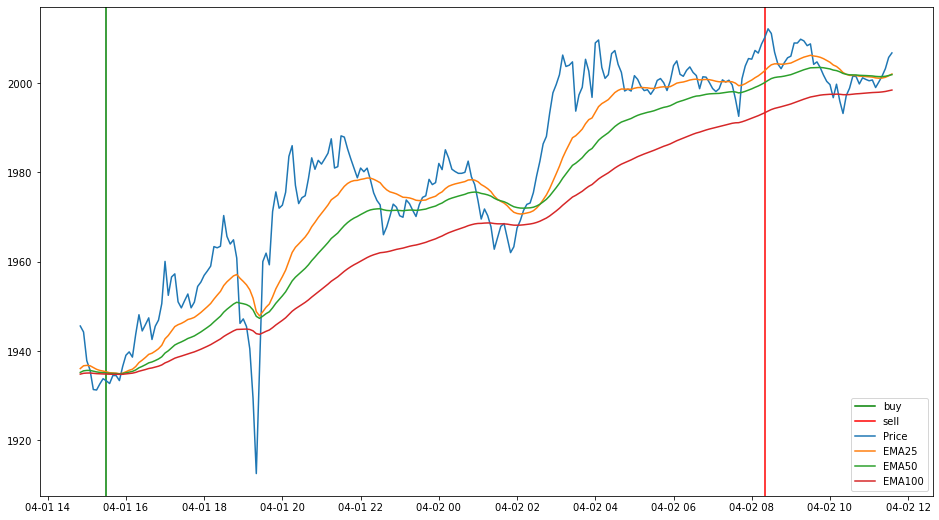

In [73]:
startWindow = 190
stopWindow = 440

buyline = 198
sellline = 400

plt.axvline(x=data.index[buyline],label="buy",color="g")
plt.axvline(x=data.index[sellline],label="sell",color="r")

plt.plot(data["Close"][startWindow:stopWindow],label="Price")
plt.plot(data["EMA25"][startWindow:stopWindow],label="EMA25")
plt.plot(data["EMA50"][startWindow:stopWindow],label="EMA50")
plt.plot(data["EMA100"][startWindow:stopWindow],label="EMA100")
plt.legend()

In [74]:
fasts = [2,5,20,25,30,45]
middles = [30,40,50,60,70,80]
slows = [80,90,100,110,150,200]

best = 0
bestStore = []

for fast in tqdm(fasts):
    for middle in middles:
        for slow in slows:
            portfolio,wins = runOnce(data.copy(),fast,middle,slow)
            medWins = np.median(wins)
            nrTrades = len(wins)
            best = portfolio[-1]
            balance = np.array(portfolio) - 40000
            medbal = np.median(balance)
            algo1 = (nrTrades/10) * medbal + (balance[-1])
            bestStore.append([portfolio[-1],medbal,medWins,nrTrades,algo1,fast,middle,slow])
            

  0%|          | 0/6 [00:00<?, ?it/s]

106 Long Buying 20 positions at 1927.80$, SL: 1923.76$, TP: 2885.64$
107 Long Sell SL, Loss: -142.75$, crntHolding: 39857.25$
107 Long Sell EMAcross, Loss: 0.00$, crntHolding: 39857.25$
113 Long Buying 20 positions at 1929.68$, SL: 1923.75$, TP: 2885.63$
142 Long Sell EMAcross, Loss: 276.84$, crntHolding: 40134.09$
145 Long Buying 20 positions at 1946.66$, SL: 1945.51$, TP: 2918.27$
148 Long Sell SL, Loss: -71.23$, crntHolding: 40062.86$
148 Long Sell EMAcross, Loss: 0.00$, crntHolding: 40062.86$
181 Long Buying 20 positions at 1936.80$, SL: 1930.93$, TP: 2896.40$
194 Long Sell EMAcross, Loss: -108.91$, crntHolding: 39953.96$
203 Long Buying 20 positions at 1936.51$, SL: 1934.97$, TP: 2902.45$
239 Long Sell EMAcross, Loss: 193.43$, crntHolding: 40147.38$
246 Long Buying 20 positions at 1960.02$, SL: 1948.95$, TP: 2923.42$
280 Long Sell EMAcross, Loss: 308.09$, crntHolding: 40455.47$
296 Long Buying 20 positions at 1974.76$, SL: 1973.76$, TP: 2960.64$
312 Long Sell SL, Loss: -20.73$, cr

2362 Long Sell SL, Loss: -231.33$, crntHolding: 43967.71$
2362 Long Sell EMAcross, Loss: 0.00$, crntHolding: 43967.71$
2388 Long Buying 21 positions at 2084.39$, SL: 2081.09$, TP: 3121.63$
2391 Long Sell SL, Loss: -96.51$, crntHolding: 43871.20$
2399 Long Buying 21 positions at 2083.38$, SL: 2081.23$, TP: 3121.85$
2402 Long Sell SL, Loss: -137.11$, crntHolding: 43734.09$
2402 Long Sell EMAcross, Loss: 0.00$, crntHolding: 43734.09$
2407 Long Buying 20 positions at 2083.67$, SL: 2081.02$, TP: 3121.53$
2410 Long Sell SL, Loss: -63.63$, crntHolding: 43670.46$
2419 Long Buying 20 positions at 2079.76$, SL: 2078.64$, TP: 3117.97$
2427 Long Sell SL, Loss: -71.85$, crntHolding: 43598.61$
2427 Long Sell EMAcross, Loss: 0.00$, crntHolding: 43598.61$
2447 Long Buying 20 positions at 2078.25$, SL: 2076.29$, TP: 3114.43$
2461 Long Sell EMAcross, Loss: 123.88$, crntHolding: 43722.49$
2465 Long Buying 20 positions at 2089.20$, SL: 2085.89$, TP: 3128.83$
2472 Long Sell EMAcross, Loss: -47.79$, crntHol

954 Long Sell SL, Loss: -257.94$, crntHolding: 42103.99$
954 Long Sell EMAcross, Loss: 0.00$, crntHolding: 42103.99$
969 Long Buying 20 positions at 2044.44$, SL: 2037.94$, TP: 3056.91$
1032 Long Sell EMAcross, Loss: 448.55$, crntHolding: 42552.54$
1035 Long Buying 20 positions at 2078.92$, SL: 2071.42$, TP: 3107.12$
1076 Long Sell EMAcross, Loss: 220.92$, crntHolding: 42773.46$
1098 Long Buying 20 positions at 2093.83$, SL: 2092.24$, TP: 3138.36$
1103 Long Sell SL, Loss: -32.85$, crntHolding: 42740.61$
1104 Long Buying 20 positions at 2095.87$, SL: 2092.69$, TP: 3139.03$
1106 Long Sell SL, Loss: -95.80$, crntHolding: 42644.82$
1106 Long Sell EMAcross, Loss: 0.00$, crntHolding: 42644.82$
1108 Long Buying 20 positions at 2093.27$, SL: 2092.70$, TP: 3139.06$
1110 Long Sell SL, Loss: -99.07$, crntHolding: 42545.74$
1110 Long Sell EMAcross, Loss: 0.00$, crntHolding: 42545.74$
1151 Long Buying 20 positions at 2084.48$, SL: 2080.31$, TP: 3120.47$
1154 Long Sell SL, Loss: -156.64$, crntHoldin

113 Long Buying 20 positions at 1929.68$, SL: 1924.24$, TP: 2886.35$
150 Long Sell EMAcross, Loss: 244.88$, crntHolding: 40244.88$
181 Long Buying 20 positions at 1936.80$, SL: 1931.96$, TP: 2897.94$
194 Long Sell SL, Loss: -108.91$, crntHolding: 40135.98$
194 Long Sell EMAcross, Loss: 0.00$, crntHolding: 40135.98$
203 Long Buying 20 positions at 1936.51$, SL: 1934.93$, TP: 2902.40$
239 Long Sell EMAcross, Loss: 193.43$, crntHolding: 40329.40$
246 Long Buying 20 positions at 1960.02$, SL: 1948.56$, TP: 2922.84$
282 Long Sell EMAcross, Loss: 253.81$, crntHolding: 40583.21$
295 Long Buying 20 positions at 1974.40$, SL: 1972.94$, TP: 2959.40$
312 Long Sell EMAcross, Loss: -13.52$, crntHolding: 40569.69$
327 Long Buying 20 positions at 1972.84$, SL: 1971.99$, TP: 2957.98$
385 Long Sell EMAcross, Loss: 505.36$, crntHolding: 41075.05$
387 Long Buying 20 positions at 2000.74$, SL: 1999.09$, TP: 2998.63$
391 Long Sell SL, Loss: -85.89$, crntHolding: 40989.16$
391 Long Sell EMAcross, Loss: 0.00

2144 Long Sell EMAcross, Loss: 176.58$, crntHolding: 41168.95$
2149 Long Buying 20 positions at 2024.83$, SL: 2022.63$, TP: 3033.95$
2150 Long Sell SL, Loss: -70.88$, crntHolding: 41098.07$
2150 Long Sell EMAcross, Loss: 0.00$, crntHolding: 41098.07$
2189 Long Buying 20 positions at 2016.43$, SL: 2006.02$, TP: 3009.02$
2283 Long Sell EMAcross, Loss: 981.90$, crntHolding: 42079.97$
2305 Long Buying 20 positions at 2065.05$, SL: 2061.98$, TP: 3092.97$
2354 Long Sell EMAcross, Loss: 403.73$, crntHolding: 42483.70$
2361 Long Buying 20 positions at 2094.43$, SL: 2085.57$, TP: 3128.36$
2362 Long Sell SL, Loss: -220.31$, crntHolding: 42263.39$
2388 Long Buying 20 positions at 2084.39$, SL: 2081.49$, TP: 3122.23$
2391 Long Sell SL, Loss: -91.91$, crntHolding: 42171.48$
2391 Long Sell EMAcross, Loss: 0.00$, crntHolding: 42171.48$
2399 Long Buying 20 positions at 2083.38$, SL: 2081.45$, TP: 3122.18$
2402 Long Sell SL, Loss: -130.58$, crntHolding: 42040.90$
2402 Long Sell EMAcross, Loss: 0.00$, c

106 Long Buying 20 positions at 1927.80$, SL: 1925.25$, TP: 2887.87$
107 Long Sell SL, Loss: -142.75$, crntHolding: 39857.25$
107 Long Sell EMAcross, Loss: 0.00$, crntHolding: 39857.25$
113 Long Buying 20 positions at 1929.68$, SL: 1924.83$, TP: 2887.25$
151 Long Sell EMAcross, Loss: 131.23$, crntHolding: 39988.48$
181 Long Buying 20 positions at 1936.80$, SL: 1932.66$, TP: 2898.99$
194 Long Sell SL, Loss: -108.91$, crntHolding: 39879.58$
194 Long Sell EMAcross, Loss: 0.00$, crntHolding: 39879.58$
203 Long Buying 20 positions at 1936.51$, SL: 1934.94$, TP: 2902.41$
240 Long Sell EMAcross, Loss: 213.53$, crntHolding: 40093.10$
246 Long Buying 20 positions at 1960.02$, SL: 1947.80$, TP: 2921.70$
283 Long Sell EMAcross, Loss: 120.40$, crntHolding: 40213.50$
286 Long Buying 20 positions at 1972.90$, SL: 1971.49$, TP: 2957.24$
288 Long Sell SL, Loss: -52.14$, crntHolding: 40161.36$
288 Long Sell EMAcross, Loss: 0.00$, crntHolding: 40161.36$
290 Long Buying 20 positions at 1973.83$, SL: 1971

1386 Long Sell EMAcross, Loss: 1074.56$, crntHolding: 43597.90$
1390 Long Buying 20 positions at 2120.71$, SL: 2118.88$, TP: 3178.32$
1391 Long Sell SL, Loss: -68.82$, crntHolding: 43529.08$
1391 Long Sell EMAcross, Loss: 0.00$, crntHolding: 43529.08$
1420 Long Buying 20 positions at 2113.95$, SL: 2110.32$, TP: 3165.48$
1426 Long Sell SL, Loss: -115.55$, crntHolding: 43413.53$
1426 Long Sell EMAcross, Loss: 0.00$, crntHolding: 43413.53$
1428 Long Buying 20 positions at 2114.73$, SL: 2111.77$, TP: 3167.66$
1434 Long Sell SL, Loss: -97.85$, crntHolding: 43315.68$
1434 Long Sell EMAcross, Loss: 0.00$, crntHolding: 43315.68$
1440 Long Buying 20 positions at 2113.20$, SL: 2112.09$, TP: 3168.13$
1443 Long Sell SL, Loss: -35.94$, crntHolding: 43279.74$
1443 Long Sell EMAcross, Loss: 0.00$, crntHolding: 43279.74$
1444 Long Buying 20 positions at 2113.92$, SL: 2112.27$, TP: 3168.41$
1452 Long Sell SL, Loss: -90.37$, crntHolding: 43189.37$
1452 Long Sell EMAcross, Loss: 0.00$, crntHolding: 43189

149 Long Buying 20 positions at 1944.07$, SL: 1942.10$, TP: 2913.16$
150 Long Sell SL, Loss: -42.89$, crntHolding: 39957.11$
181 Long Buying 20 positions at 1936.80$, SL: 1932.66$, TP: 2898.99$
194 Long Sell SL, Loss: -108.91$, crntHolding: 39848.21$
194 Long Sell EMAcross, Loss: 0.00$, crntHolding: 39848.21$
203 Long Buying 20 positions at 1936.51$, SL: 1934.94$, TP: 2902.41$
240 Long Sell EMAcross, Loss: 213.53$, crntHolding: 40061.73$
246 Long Buying 20 positions at 1960.02$, SL: 1947.80$, TP: 2921.70$
283 Long Sell EMAcross, Loss: 120.40$, crntHolding: 40182.13$
286 Long Buying 20 positions at 1972.90$, SL: 1971.49$, TP: 2957.24$
288 Long Sell SL, Loss: -52.14$, crntHolding: 40129.99$
288 Long Sell EMAcross, Loss: 0.00$, crntHolding: 40129.99$
290 Long Buying 20 positions at 1973.83$, SL: 1971.51$, TP: 2957.26$
292 Long Sell SL, Loss: -46.90$, crntHolding: 40083.08$
294 Long Buying 20 positions at 1972.78$, SL: 1971.56$, TP: 2957.33$
312 Long Sell EMAcross, Loss: 18.95$, crntHoldin

3707 Long Sell EMAcross, Loss: 1908.85$, crntHolding: 44631.49$
3708 Long Buying 19 positions at 2280.26$, SL: 2277.39$, TP: 3416.08$
3714 Long Sell SL, Loss: -203.45$, crntHolding: 44428.04$
3714 Long Sell EMAcross, Loss: 0.00$, crntHolding: 44428.04$
3715 Long Buying 19 positions at 2280.58$, SL: 2278.31$, TP: 3417.47$
3739 Long Sell EMAcross, Loss: 79.96$, crntHolding: 44508.00$
3741 Long Buying 19 positions at 2290.94$, SL: 2287.71$, TP: 3431.56$
3742 Long Sell SL, Loss: -69.43$, crntHolding: 44438.57$
113 Long Buying 20 positions at 1929.68$, SL: 1925.44$, TP: 2888.16$
151 Long Sell EMAcross, Loss: 131.23$, crntHolding: 40131.23$
181 Long Buying 20 positions at 1936.80$, SL: 1933.09$, TP: 2899.64$
194 Long Sell SL, Loss: -108.91$, crntHolding: 40022.32$
194 Long Sell EMAcross, Loss: 0.00$, crntHolding: 40022.32$
203 Long Buying 20 positions at 1936.51$, SL: 1934.95$, TP: 2902.42$
240 Long Sell EMAcross, Loss: 213.53$, crntHolding: 40235.85$
246 Long Buying 20 positions at 1960.02$

3344 Long Buying 19 positions at 2159.93$, SL: 2157.74$, TP: 3236.60$
3345 Long Sell SL, Loss: -42.54$, crntHolding: 41511.14$
3348 Long Buying 19 positions at 2157.94$, SL: 2157.73$, TP: 3236.60$
3353 Long Sell SL, Loss: -9.25$, crntHolding: 41501.89$
3354 Long Buying 19 positions at 2159.19$, SL: 2158.04$, TP: 3237.06$
3358 Long Sell SL, Loss: -82.44$, crntHolding: 41419.45$
3358 Long Sell EMAcross, Loss: 0.00$, crntHolding: 41419.45$
3436 Long Buying 19 positions at 2151.91$, SL: 2139.53$, TP: 3209.29$
3474 Long Sell EMAcross, Loss: -143.83$, crntHolding: 41275.62$
3482 Long Buying 19 positions at 2156.85$, SL: 2145.71$, TP: 3218.56$
3561 Long Sell EMAcross, Loss: 69.27$, crntHolding: 41344.89$
3565 Long Buying 19 positions at 2170.57$, SL: 2165.99$, TP: 3248.98$
3566 Long Sell SL, Loss: -144.34$, crntHolding: 41200.55$
3566 Long Sell EMAcross, Loss: 0.00$, crntHolding: 41200.55$
3573 Long Buying 19 positions at 2167.51$, SL: 2165.10$, TP: 3247.65$
3707 Long Sell EMAcross, Loss: 190

3196 Long Sell SL, Loss: -22.53$, crntHolding: 42257.49$
3207 Long Buying 19 positions at 2153.88$, SL: 2148.00$, TP: 3222.00$
3216 Long Sell SL, Loss: -139.19$, crntHolding: 42118.30$
3216 Long Sell EMAcross, Loss: 0.00$, crntHolding: 42118.30$
3236 Long Buying 19 positions at 2147.99$, SL: 2145.55$, TP: 3218.32$
3259 Long Sell EMAcross, Loss: 2.10$, crntHolding: 42120.40$
3267 Long Buying 19 positions at 2151.50$, SL: 2149.05$, TP: 3223.57$
3308 Long Sell EMAcross, Loss: 315.03$, crntHolding: 42435.42$
3349 Long Buying 19 positions at 2158.97$, SL: 2158.23$, TP: 3237.35$
3353 Long Sell SL, Loss: -28.90$, crntHolding: 42406.53$
3354 Long Buying 19 positions at 2159.19$, SL: 2158.41$, TP: 3237.61$
3355 Long Sell SL, Loss: -15.15$, crntHolding: 42391.37$
3356 Long Buying 19 positions at 2161.90$, SL: 2158.50$, TP: 3237.76$
3357 Long Sell SL, Loss: -72.25$, crntHolding: 42319.12$
3421 Long Buying 19 positions at 2142.73$, SL: 2137.45$, TP: 3206.18$
3474 Long Sell EMAcross, Loss: 30.68$, 

2372 Long Buying 20 positions at 2080.52$, SL: 2079.96$, TP: 3119.94$
2375 Long Sell SL, Loss: -16.08$, crntHolding: 42632.05$
2375 Long Sell EMAcross, Loss: 0.00$, crntHolding: 42632.05$
2376 Long Buying 20 positions at 2080.59$, SL: 2079.99$, TP: 3119.98$
2382 Long Sell SL, Loss: -51.19$, crntHolding: 42580.86$
2382 Long Sell EMAcross, Loss: 0.00$, crntHolding: 42580.86$
2388 Long Buying 20 positions at 2084.39$, SL: 2079.94$, TP: 3119.92$
2391 Long Sell SL, Loss: -91.91$, crntHolding: 42488.95$
2392 Long Buying 20 positions at 2080.36$, SL: 2080.23$, TP: 3120.34$
2393 Long Sell SL, Loss: -3.28$, crntHolding: 42485.67$
2394 Long Buying 20 positions at 2080.40$, SL: 2080.23$, TP: 3120.35$
2396 Long Sell SL, Loss: -5.72$, crntHolding: 42479.95$
2399 Long Buying 20 positions at 2083.38$, SL: 2080.31$, TP: 3120.47$
2402 Long Sell SL, Loss: -130.58$, crntHolding: 42349.37$
2402 Long Sell EMAcross, Loss: 0.00$, crntHolding: 42349.37$
2406 Long Buying 20 positions at 2080.95$, SL: 2080.30$,

1295 Long Buying 20 positions at 2063.73$, SL: 2052.36$, TP: 3078.54$
1395 Long Sell EMAcross, Loss: 774.51$, crntHolding: 42789.98$
1408 Long Buying 20 positions at 2110.70$, SL: 2108.21$, TP: 3162.32$
1409 Long Sell SL, Loss: -110.91$, crntHolding: 42679.06$
1409 Long Sell EMAcross, Loss: 0.00$, crntHolding: 42679.06$
1416 Long Buying 20 positions at 2109.14$, SL: 2107.83$, TP: 3161.74$
1417 Long Sell SL, Loss: -84.80$, crntHolding: 42594.26$
1417 Long Sell EMAcross, Loss: 0.00$, crntHolding: 42594.26$
1419 Long Buying 20 positions at 2110.54$, SL: 2107.79$, TP: 3161.68$
1427 Long Sell SL, Loss: -79.40$, crntHolding: 42514.86$
1427 Long Sell EMAcross, Loss: 0.00$, crntHolding: 42514.86$
1428 Long Buying 20 positions at 2114.73$, SL: 2109.37$, TP: 3164.05$
1453 Long Sell SL, Loss: -197.41$, crntHolding: 42317.45$
1453 Long Sell EMAcross, Loss: 0.00$, crntHolding: 42317.45$
1464 Long Buying 20 positions at 2115.15$, SL: 2109.22$, TP: 3163.82$
1489 Long Sell EMAcross, Loss: -4.93$, crnt

 17%|█▋        | 1/6 [00:01<00:09,  1.99s/it]

114 Long Buying 20 positions at 1933.42$, SL: 1924.38$, TP: 2886.57$
144 Long Sell EMAcross, Loss: 224.81$, crntHolding: 40224.81$
145 Long Buying 20 positions at 1946.66$, SL: 1945.51$, TP: 2918.27$
148 Long Sell SL, Loss: -71.23$, crntHolding: 40153.58$
148 Long Sell EMAcross, Loss: 0.00$, crntHolding: 40153.58$
183 Long Buying 20 positions at 1934.60$, SL: 1931.51$, TP: 2897.27$
194 Long Sell SL, Loss: -64.92$, crntHolding: 40088.66$
204 Long Buying 20 positions at 1939.03$, SL: 1935.23$, TP: 2902.84$
240 Long Sell EMAcross, Loss: 163.03$, crntHolding: 40251.69$
248 Long Buying 20 positions at 1959.30$, SL: 1950.40$, TP: 2925.60$
282 Long Sell EMAcross, Loss: 268.22$, crntHolding: 40519.91$
297 Long Buying 20 positions at 1978.45$, SL: 1974.06$, TP: 2961.09$
312 Long Sell SL, Loss: -94.37$, crntHolding: 40425.53$
312 Long Sell EMAcross, Loss: 0.00$, crntHolding: 40425.53$
329 Long Buying 20 positions at 1975.47$, SL: 1971.78$, TP: 2957.67$
384 Long Sell EMAcross, Loss: 466.44$, crnt

2349 Long Sell EMAcross, Loss: 448.34$, crntHolding: 42782.37$
2361 Long Buying 20 positions at 2094.43$, SL: 2086.57$, TP: 3129.86$
2362 Long Sell SL, Loss: -220.31$, crntHolding: 42562.05$
2362 Long Sell EMAcross, Loss: 0.00$, crntHolding: 42562.05$
2389 Long Buying 20 positions at 2085.85$, SL: 2081.40$, TP: 3122.09$
2391 Long Sell SL, Loss: -121.14$, crntHolding: 42440.91$
2392 Long Buying 20 positions at 2080.36$, SL: 2081.49$, TP: 3122.24$
2393 Long Sell SL, Loss: -3.28$, crntHolding: 42437.63$
2393 Long Sell EMAcross, Loss: 0.00$, crntHolding: 42437.63$
2399 Long Buying 20 positions at 2083.38$, SL: 2081.23$, TP: 3121.85$
2402 Long Sell SL, Loss: -130.58$, crntHolding: 42307.05$
2402 Long Sell EMAcross, Loss: 0.00$, crntHolding: 42307.05$
2407 Long Buying 20 positions at 2083.67$, SL: 2081.02$, TP: 3121.53$
2410 Long Sell SL, Loss: -63.63$, crntHolding: 42243.42$
2421 Long Buying 20 positions at 2081.68$, SL: 2078.91$, TP: 3118.36$
2425 Long Sell SL, Loss: -60.07$, crntHolding: 

3474 Long Sell EMAcross, Loss: 60.01$, crntHolding: 41442.48$
3482 Long Buying 19 positions at 2156.85$, SL: 2146.44$, TP: 3219.65$
3536 Long Sell EMAcross, Loss: 71.67$, crntHolding: 41514.15$
3545 Long Buying 19 positions at 2164.78$, SL: 2163.63$, TP: 3245.44$
3551 Long Sell SL, Loss: -31.05$, crntHolding: 41483.10$
3552 Long Buying 19 positions at 2166.37$, SL: 2164.14$, TP: 3246.21$
3561 Long Sell SL, Loss: -111.54$, crntHolding: 41371.56$
3574 Long Buying 19 positions at 2172.51$, SL: 2166.27$, TP: 3249.41$
3707 Long Sell EMAcross, Loss: 1813.89$, crntHolding: 43185.45$
3718 Long Buying 18 positions at 2301.08$, SL: 2286.03$, TP: 3429.05$
3738 Long Sell EMAcross, Loss: -263.94$, crntHolding: 42921.51$
114 Long Buying 20 positions at 1933.42$, SL: 1924.68$, TP: 2887.03$
151 Long Sell EMAcross, Loss: 56.50$, crntHolding: 40056.50$
184 Long Buying 20 positions at 1934.21$, SL: 1932.40$, TP: 2898.60$
194 Long Sell SL, Loss: -57.24$, crntHolding: 39999.26$
204 Long Buying 20 positions

2593 Long Buying 19 positions at 2079.32$, SL: 2078.80$, TP: 3118.20$
2594 Long Sell SL, Loss: -21.77$, crntHolding: 40907.89$
2594 Long Sell EMAcross, Loss: 0.00$, crntHolding: 40907.89$
2635 Long Buying 19 positions at 2078.29$, SL: 2072.60$, TP: 3108.90$
2709 Long Sell EMAcross, Loss: 1563.61$, crntHolding: 42471.50$
2712 Long Buying 19 positions at 2176.77$, SL: 2164.81$, TP: 3247.22$
2724 Long Sell EMAcross, Loss: -215.84$, crntHolding: 42255.66$
2725 Long Buying 19 positions at 2168.11$, SL: 2167.26$, TP: 3250.89$
2729 Long Sell SL, Loss: -25.51$, crntHolding: 42230.15$
2730 Long Buying 19 positions at 2167.13$, SL: 2167.38$, TP: 3251.07$
2731 Long Sell SL, Loss: 0.83$, crntHolding: 42230.98$
2732 Long Buying 19 positions at 2167.56$, SL: 2167.38$, TP: 3251.07$
2744 Long Sell SL, Loss: -43.73$, crntHolding: 42187.25$
2787 Long Buying 19 positions at 2158.28$, SL: 2156.90$, TP: 3235.35$
2788 Long Sell SL, Loss: -49.43$, crntHolding: 42137.81$
2788 Long Sell EMAcross, Loss: 0.00$, 

114 Long Buying 20 positions at 1933.42$, SL: 1925.17$, TP: 2887.75$
151 Long Sell EMAcross, Loss: 56.50$, crntHolding: 40056.50$
183 Long Buying 20 positions at 1934.60$, SL: 1932.89$, TP: 2899.33$
194 Long Sell SL, Loss: -64.92$, crntHolding: 39991.57$
204 Long Buying 20 positions at 1939.03$, SL: 1935.10$, TP: 2902.65$
242 Long Sell EMAcross, Loss: 29.05$, crntHolding: 40020.62$
247 Long Buying 20 positions at 1961.92$, SL: 1948.35$, TP: 2922.53$
284 Long Sell EMAcross, Loss: 117.26$, crntHolding: 40137.88$
287 Long Buying 20 positions at 1972.21$, SL: 1971.52$, TP: 2957.28$
288 Long Sell SL, Loss: -38.43$, crntHolding: 40099.45$
288 Long Sell EMAcross, Loss: 0.00$, crntHolding: 40099.45$
290 Long Buying 20 positions at 1973.83$, SL: 1971.51$, TP: 2957.26$
292 Long Sell SL, Loss: -46.90$, crntHolding: 40052.55$
294 Long Buying 20 positions at 1972.78$, SL: 1971.56$, TP: 2957.33$
313 Long Sell SL, Loss: -64.49$, crntHolding: 39988.06$
313 Long Sell EMAcross, Loss: 0.00$, crntHolding:

114 Long Buying 20 positions at 1933.42$, SL: 1925.17$, TP: 2887.75$
151 Long Sell EMAcross, Loss: 56.50$, crntHolding: 40056.50$
183 Long Buying 20 positions at 1934.60$, SL: 1932.89$, TP: 2899.33$
194 Long Sell SL, Loss: -64.92$, crntHolding: 39991.57$
204 Long Buying 20 positions at 1939.03$, SL: 1935.10$, TP: 2902.65$
242 Long Sell EMAcross, Loss: 29.05$, crntHolding: 40020.62$
247 Long Buying 20 positions at 1961.92$, SL: 1948.35$, TP: 2922.53$
284 Long Sell EMAcross, Loss: 117.26$, crntHolding: 40137.88$
287 Long Buying 20 positions at 1972.21$, SL: 1971.52$, TP: 2957.28$
288 Long Sell SL, Loss: -38.43$, crntHolding: 40099.45$
288 Long Sell EMAcross, Loss: 0.00$, crntHolding: 40099.45$
290 Long Buying 20 positions at 1973.83$, SL: 1971.51$, TP: 2957.26$
292 Long Sell SL, Loss: -46.90$, crntHolding: 40052.55$
294 Long Buying 20 positions at 1972.78$, SL: 1971.56$, TP: 2957.33$
313 Long Sell SL, Loss: -64.49$, crntHolding: 39988.06$
313 Long Sell EMAcross, Loss: 0.00$, crntHolding:

983 Long Buying 20 positions at 2055.66$, SL: 2042.59$, TP: 3063.89$
1080 Long Sell EMAcross, Loss: 759.32$, crntHolding: 41872.55$
1081 Long Buying 19 positions at 2096.00$, SL: 2094.69$, TP: 3142.04$
1082 Long Sell SL, Loss: -37.85$, crntHolding: 41834.69$
1082 Long Sell EMAcross, Loss: 0.00$, crntHolding: 41834.69$
1099 Long Buying 19 positions at 2094.19$, SL: 2091.94$, TP: 3137.90$
1106 Long Sell SL, Loss: -59.21$, crntHolding: 41775.49$
1107 Long Buying 19 positions at 2092.56$, SL: 2092.33$, TP: 3138.50$
1110 Long Sell SL, Loss: -80.56$, crntHolding: 41694.92$
1110 Long Sell EMAcross, Loss: 0.00$, crntHolding: 41694.92$
1151 Long Buying 20 positions at 2084.48$, SL: 2081.24$, TP: 3121.86$
1153 Long Sell SL, Loss: -75.29$, crntHolding: 41619.63$
1157 Long Buying 19 positions at 2084.23$, SL: 2081.08$, TP: 3121.62$
1161 Long Sell SL, Loss: -60.58$, crntHolding: 41559.05$
1162 Long Buying 19 positions at 2081.97$, SL: 2081.30$, TP: 3121.95$
1184 Long Sell SL, Loss: -26.15$, crntHol

987 Long Buying 19 positions at 2065.99$, SL: 2044.98$, TP: 3067.47$
1080 Long Sell EMAcross, Loss: 525.03$, crntHolding: 41683.68$
1081 Long Buying 19 positions at 2096.00$, SL: 2094.69$, TP: 3142.04$
1082 Long Sell SL, Loss: -37.85$, crntHolding: 41645.83$
1082 Long Sell EMAcross, Loss: 0.00$, crntHolding: 41645.83$
1099 Long Buying 19 positions at 2094.19$, SL: 2091.94$, TP: 3137.90$
1106 Long Sell SL, Loss: -59.21$, crntHolding: 41586.62$
1107 Long Buying 19 positions at 2092.56$, SL: 2092.33$, TP: 3138.50$
1110 Long Sell SL, Loss: -80.56$, crntHolding: 41506.05$
1110 Long Sell EMAcross, Loss: 0.00$, crntHolding: 41506.05$
1151 Long Buying 19 positions at 2084.48$, SL: 2081.24$, TP: 3121.86$
1153 Long Sell SL, Loss: -71.53$, crntHolding: 41434.53$
1157 Long Buying 19 positions at 2084.23$, SL: 2081.08$, TP: 3121.62$
1161 Long Sell SL, Loss: -60.58$, crntHolding: 41373.95$
1162 Long Buying 19 positions at 2081.97$, SL: 2081.30$, TP: 3121.95$
1184 Long Sell SL, Loss: -26.15$, crntHol

2189 Long Buying 20 positions at 2016.43$, SL: 2007.73$, TP: 3011.59$
2290 Long Sell EMAcross, Loss: 822.68$, crntHolding: 41458.72$
2306 Long Buying 20 positions at 2062.85$, SL: 2061.49$, TP: 3092.24$
2365 Long Sell EMAcross, Loss: 355.33$, crntHolding: 41814.05$
2389 Long Buying 20 positions at 2085.85$, SL: 2081.37$, TP: 3122.06$
2391 Long Sell SL, Loss: -121.14$, crntHolding: 41692.91$
2392 Long Buying 20 positions at 2080.36$, SL: 2081.43$, TP: 3122.15$
2393 Long Sell SL, Loss: -3.28$, crntHolding: 41689.63$
2393 Long Sell EMAcross, Loss: 0.00$, crntHolding: 41689.63$
2399 Long Buying 20 positions at 2083.38$, SL: 2081.29$, TP: 3121.93$
2402 Long Sell SL, Loss: -130.58$, crntHolding: 41559.05$
2402 Long Sell EMAcross, Loss: 0.00$, crntHolding: 41559.05$
2407 Long Buying 19 positions at 2083.67$, SL: 2081.15$, TP: 3121.73$
2410 Long Sell SL, Loss: -60.45$, crntHolding: 41498.60$
2423 Long Buying 19 positions at 2080.65$, SL: 2079.81$, TP: 3119.72$
2425 Long Sell SL, Loss: -37.44$,

1608 Long Buying 19 positions at 2126.91$, SL: 2117.80$, TP: 3176.70$
1619 Long Sell SL, Loss: -260.57$, crntHolding: 41797.41$
1620 Long Buying 19 positions at 2121.06$, SL: 2120.19$, TP: 3180.28$
1621 Long Sell SL, Loss: -48.74$, crntHolding: 41748.67$
1666 Long Buying 19 positions at 2112.60$, SL: 2099.16$, TP: 3148.74$
1701 Long Sell EMAcross, Loss: -71.12$, crntHolding: 41677.54$
1703 Long Buying 19 positions at 2118.37$, SL: 2114.60$, TP: 3171.90$
1720 Long Sell SL, Loss: -114.15$, crntHolding: 41563.39$
1726 Long Buying 19 positions at 2125.26$, SL: 2117.35$, TP: 3176.03$
1728 Long Sell SL, Loss: -262.67$, crntHolding: 41300.71$
1728 Long Sell EMAcross, Loss: 0.00$, crntHolding: 41300.71$
1732 Long Buying 19 positions at 2123.17$, SL: 2117.12$, TP: 3175.68$
1761 Long Sell SL, Loss: -392.11$, crntHolding: 40908.61$
1761 Long Sell EMAcross, Loss: 0.00$, crntHolding: 40908.61$
1786 Long Buying 19 positions at 2115.24$, SL: 2111.99$, TP: 3167.98$
1789 Long Sell SL, Loss: -111.02$, c

114 Long Buying 20 positions at 1933.42$, SL: 1926.23$, TP: 2889.34$
153 Long Sell EMAcross, Loss: 98.37$, crntHolding: 40098.37$
183 Long Buying 20 positions at 1934.60$, SL: 1933.47$, TP: 2900.21$
194 Long Sell SL, Loss: -64.92$, crntHolding: 40033.44$
204 Long Buying 20 positions at 1939.03$, SL: 1935.04$, TP: 2902.56$
243 Long Sell SL, Loss: -192.65$, crntHolding: 39840.79$
243 Long Sell EMAcross, Loss: 0.00$, crntHolding: 39840.79$
247 Long Buying 20 positions at 1961.92$, SL: 1946.59$, TP: 2919.89$
316 Long Sell EMAcross, Loss: 118.14$, crntHolding: 39958.93$
329 Long Buying 20 positions at 1975.47$, SL: 1971.22$, TP: 2956.83$
421 Long Sell EMAcross, Loss: 425.50$, crntHolding: 40384.43$
436 Long Buying 20 positions at 2001.61$, SL: 2000.54$, TP: 3000.81$
475 Long Sell SL, Loss: -37.90$, crntHolding: 40346.53$
475 Long Sell EMAcross, Loss: 0.00$, crntHolding: 40346.53$
479 Long Buying 20 positions at 2009.66$, SL: 2006.19$, TP: 3009.29$
621 Long Sell EMAcross, Loss: 1712.15$, crn

727 Long Sell SL, Loss: -156.20$, crntHolding: 41566.75$
727 Long Sell EMAcross, Loss: 0.00$, crntHolding: 41566.75$
754 Long Buying 19 positions at 2118.17$, SL: 2114.44$, TP: 3171.66$
756 Long Sell SL, Loss: -97.73$, crntHolding: 41469.02$
756 Long Sell EMAcross, Loss: 0.00$, crntHolding: 41469.02$
759 Long Buying 19 positions at 2119.73$, SL: 2114.54$, TP: 3171.82$
779 Long Sell SL, Loss: -165.15$, crntHolding: 41303.88$
779 Long Sell EMAcross, Loss: 0.00$, crntHolding: 41303.88$
832 Long Buying 19 positions at 2103.07$, SL: 2087.78$, TP: 3131.67$
849 Long Sell SL, Loss: -405.16$, crntHolding: 40898.72$
972 Long Buying 19 positions at 2047.81$, SL: 2040.00$, TP: 3060.00$
1085 Long Sell EMAcross, Loss: 663.62$, crntHolding: 41562.34$
1097 Long Buying 19 positions at 2092.37$, SL: 2089.69$, TP: 3134.53$
1110 Long Sell SL, Loss: -77.03$, crntHolding: 41485.32$
1164 Long Buying 19 positions at 2087.83$, SL: 2082.35$, TP: 3123.53$
1184 Long Sell SL, Loss: -137.33$, crntHolding: 41347.99$

114 Long Buying 20 positions at 1933.42$, SL: 1926.73$, TP: 2890.10$
154 Long Sell EMAcross, Loss: 68.26$, crntHolding: 40068.26$
183 Long Buying 20 positions at 1934.60$, SL: 1933.59$, TP: 2900.39$
194 Long Sell SL, Loss: -64.92$, crntHolding: 40003.34$
204 Long Buying 20 positions at 1939.03$, SL: 1934.98$, TP: 2902.48$
243 Long Sell SL, Loss: -192.65$, crntHolding: 39810.69$
243 Long Sell EMAcross, Loss: 0.00$, crntHolding: 39810.69$
247 Long Buying 20 positions at 1961.92$, SL: 1945.79$, TP: 2918.69$
316 Long Sell EMAcross, Loss: 118.14$, crntHolding: 39928.83$
328 Long Buying 20 positions at 1973.14$, SL: 1970.30$, TP: 2955.45$
423 Long Sell EMAcross, Loss: 457.49$, crntHolding: 40386.31$
428 Long Buying 20 positions at 2001.50$, SL: 1999.66$, TP: 2999.49$
434 Long Sell SL, Loss: -49.50$, crntHolding: 40336.82$
435 Long Buying 20 positions at 2000.28$, SL: 1999.77$, TP: 2999.66$
475 Long Sell SL, Loss: -11.27$, crntHolding: 40325.55$
475 Long Sell EMAcross, Loss: 0.00$, crntHoldin

114 Long Buying 20 positions at 1933.42$, SL: 1926.73$, TP: 2890.10$
154 Long Sell EMAcross, Loss: 68.26$, crntHolding: 40068.26$
183 Long Buying 20 positions at 1934.60$, SL: 1933.59$, TP: 2900.39$
194 Long Sell SL, Loss: -64.92$, crntHolding: 40003.34$
204 Long Buying 20 positions at 1939.03$, SL: 1934.98$, TP: 2902.48$
243 Long Sell SL, Loss: -192.65$, crntHolding: 39810.69$
243 Long Sell EMAcross, Loss: 0.00$, crntHolding: 39810.69$
247 Long Buying 20 positions at 1961.92$, SL: 1945.79$, TP: 2918.69$
316 Long Sell EMAcross, Loss: 118.14$, crntHolding: 39928.83$
328 Long Buying 20 positions at 1973.14$, SL: 1970.30$, TP: 2955.45$
423 Long Sell EMAcross, Loss: 457.49$, crntHolding: 40386.31$
428 Long Buying 20 positions at 2001.50$, SL: 1999.66$, TP: 2999.49$
434 Long Sell SL, Loss: -49.50$, crntHolding: 40336.82$
435 Long Buying 20 positions at 2000.28$, SL: 1999.77$, TP: 2999.66$
475 Long Sell SL, Loss: -11.27$, crntHolding: 40325.55$
475 Long Sell EMAcross, Loss: 0.00$, crntHoldin

204 Long Buying 20 positions at 1939.03$, SL: 1934.98$, TP: 2902.48$
243 Long Sell SL, Loss: -192.65$, crntHolding: 39807.35$
243 Long Sell EMAcross, Loss: 0.00$, crntHolding: 39807.35$
247 Long Buying 20 positions at 1961.92$, SL: 1945.79$, TP: 2918.69$
316 Long Sell EMAcross, Loss: 118.14$, crntHolding: 39925.49$
328 Long Buying 20 positions at 1973.14$, SL: 1970.30$, TP: 2955.45$
423 Long Sell EMAcross, Loss: 457.49$, crntHolding: 40382.97$
428 Long Buying 20 positions at 2001.50$, SL: 1999.66$, TP: 2999.49$
434 Long Sell SL, Loss: -49.50$, crntHolding: 40333.48$
435 Long Buying 20 positions at 2000.28$, SL: 1999.77$, TP: 2999.66$
475 Long Sell SL, Loss: -11.27$, crntHolding: 40322.21$
475 Long Sell EMAcross, Loss: 0.00$, crntHolding: 40322.21$
479 Long Buying 20 positions at 2009.66$, SL: 2005.58$, TP: 3008.37$
621 Long Sell EMAcross, Loss: 1712.15$, crntHolding: 42034.36$
633 Long Buying 19 positions at 2112.41$, SL: 2107.90$, TP: 3161.85$
642 Long Sell SL, Loss: -97.28$, crntHold

 33%|███▎      | 2/6 [00:03<00:07,  1.92s/it]


1164 Long Buying 19 positions at 2087.83$, SL: 2082.53$, TP: 3123.80$
1184 Long Sell SL, Loss: -137.33$, crntHolding: 41164.73$
1298 Long Buying 19 positions at 2063.07$, SL: 2053.12$, TP: 3079.68$
1396 Long Sell EMAcross, Loss: 675.80$, crntHolding: 41840.53$
1419 Long Buying 19 positions at 2110.54$, SL: 2107.79$, TP: 3161.68$
1427 Long Sell SL, Loss: -75.43$, crntHolding: 41765.09$
1428 Long Buying 19 positions at 2114.73$, SL: 2109.37$, TP: 3164.05$
1453 Long Sell SL, Loss: -187.54$, crntHolding: 41577.56$
1465 Long Buying 19 positions at 2122.10$, SL: 2109.53$, TP: 3164.30$
1520 Long Sell EMAcross, Loss: -46.53$, crntHolding: 41531.02$
1522 Long Buying 19 positions at 2126.95$, SL: 2122.63$, TP: 3183.94$
1554 Long Sell SL, Loss: -114.83$, crntHolding: 41416.19$
1554 Long Sell EMAcross, Loss: 0.00$, crntHolding: 41416.19$
1589 Long Buying 19 positions at 2127.09$, SL: 2117.93$, TP: 3176.90$
1595 Long Sell SL, Loss: -371.33$, crntHolding: 41044.85$
1605 Long Buying 19 positions at 

149 Long Buying 20 positions at 1944.07$, SL: 1945.33$, TP: 2918.00$
150 Long Sell SL, Loss: -42.89$, crntHolding: 39957.11$
151 Long Buying 20 positions at 1936.24$, SL: 1944.54$, TP: 2916.81$
152 Long Sell SL, Loss: 25.54$, crntHolding: 39982.65$
153 Long Buying 20 positions at 1938.34$, SL: 1943.72$, TP: 2915.58$
154 Long Sell SL, Loss: -30.10$, crntHolding: 39952.55$
154 Long Sell EMAcross, Loss: 0.00$, crntHolding: 39952.55$
188 Long Buying 20 positions at 1944.16$, SL: 1934.19$, TP: 2901.29$
194 Long Sell SL, Loss: -256.21$, crntHolding: 39696.34$
195 Long Buying 20 positions at 1931.25$, SL: 1935.62$, TP: 2903.44$
196 Long Sell SL, Loss: 27.19$, crntHolding: 39723.53$
197 Long Buying 20 positions at 1933.79$, SL: 1935.32$, TP: 2902.99$
198 Long Sell SL, Loss: -9.93$, crntHolding: 39713.60$
199 Long Buying 20 positions at 1932.70$, SL: 1935.03$, TP: 2902.55$
200 Long Sell SL, Loss: 35.97$, crntHolding: 39749.57$
201 Long Buying 20 positions at 1934.48$, SL: 1934.96$, TP: 2902.45$

3066 Long Sell SL, Loss: -154.81$, crntHolding: 39737.05$
3066 Long Sell EMAcross, Loss: 0.00$, crntHolding: 39737.05$
3086 Long Buying 18 positions at 2150.12$, SL: 2140.53$, TP: 3210.79$
3109 Long Sell SL, Loss: -195.76$, crntHolding: 39541.29$
3110 Long Buying 18 positions at 2140.79$, SL: 2146.65$, TP: 3219.97$
3111 Long Sell SL, Loss: 36.95$, crntHolding: 39578.24$
3112 Long Buying 18 positions at 2147.03$, SL: 2146.49$, TP: 3219.73$
3138 Long Sell SL, Loss: -45.47$, crntHolding: 39532.77$
3139 Long Buying 18 positions at 2152.66$, SL: 2152.40$, TP: 3228.60$
3141 Long Sell SL, Loss: -100.82$, crntHolding: 39431.95$
3142 Long Buying 18 positions at 2145.65$, SL: 2152.08$, TP: 3228.12$
3143 Long Sell SL, Loss: 44.23$, crntHolding: 39476.18$
3144 Long Buying 18 positions at 2148.13$, SL: 2151.70$, TP: 3227.55$
3145 Long Sell SL, Loss: 14.75$, crntHolding: 39490.93$
3146 Long Buying 18 positions at 2148.05$, SL: 2151.40$, TP: 3227.09$
3147 Long Sell SL, Loss: 27.91$, crntHolding: 3951

121 Long Buying 20 positions at 1935.50$, SL: 1926.80$, TP: 2890.19$
157 Long Sell SL, Loss: -218.69$, crntHolding: 39781.31$
157 Long Sell EMAcross, Loss: 0.00$, crntHolding: 39781.31$
188 Long Buying 20 positions at 1944.16$, SL: 1934.33$, TP: 2901.49$
194 Long Sell SL, Loss: -256.21$, crntHolding: 39525.10$
195 Long Buying 20 positions at 1931.25$, SL: 1935.30$, TP: 2902.96$
196 Long Sell SL, Loss: 27.19$, crntHolding: 39552.29$
197 Long Buying 20 positions at 1933.79$, SL: 1935.14$, TP: 2902.72$
198 Long Sell SL, Loss: -9.93$, crntHolding: 39542.36$
199 Long Buying 20 positions at 1932.70$, SL: 1934.98$, TP: 2902.47$
200 Long Sell SL, Loss: 35.97$, crntHolding: 39578.33$
201 Long Buying 20 positions at 1934.48$, SL: 1934.94$, TP: 2902.41$
202 Long Sell SL, Loss: -22.49$, crntHolding: 39555.84$
203 Long Buying 20 positions at 1936.51$, SL: 1934.94$, TP: 2902.41$
243 Long Sell SL, Loss: -142.16$, crntHolding: 39413.68$
244 Long Buying 20 positions at 1912.53$, SL: 1947.75$, TP: 2921.

120 Long Buying 20 positions at 1935.87$, SL: 1926.68$, TP: 2890.02$
157 Long Sell SL, Loss: -226.19$, crntHolding: 39773.81$
188 Long Buying 20 positions at 1944.16$, SL: 1934.41$, TP: 2901.62$
194 Long Sell SL, Loss: -256.21$, crntHolding: 39517.60$
195 Long Buying 20 positions at 1931.25$, SL: 1935.24$, TP: 2902.87$
196 Long Sell SL, Loss: 27.19$, crntHolding: 39544.79$
197 Long Buying 20 positions at 1933.79$, SL: 1935.11$, TP: 2902.67$
198 Long Sell SL, Loss: -9.93$, crntHolding: 39534.86$
199 Long Buying 20 positions at 1932.70$, SL: 1934.98$, TP: 2902.46$
200 Long Sell SL, Loss: 35.97$, crntHolding: 39570.83$
201 Long Buying 20 positions at 1934.48$, SL: 1934.94$, TP: 2902.42$
202 Long Sell SL, Loss: -22.49$, crntHolding: 39548.34$
203 Long Buying 20 positions at 1936.51$, SL: 1934.95$, TP: 2902.42$
243 Long Sell SL, Loss: -142.16$, crntHolding: 39406.18$
244 Long Buying 20 positions at 1912.53$, SL: 1946.87$, TP: 2920.30$
245 Long Sell SL, Loss: 475.74$, crntHolding: 39881.92$


3311 Long Sell SL, Loss: -102.21$, crntHolding: 40229.78$
3312 Long Buying 18 positions at 2153.95$, SL: 2172.10$, TP: 3258.15$
3313 Long Sell SL, Loss: 112.23$, crntHolding: 40342.01$
3439 Long Buying 18 positions at 2151.76$, SL: 2140.52$, TP: 3210.77$
3479 Long Sell SL, Loss: -223.26$, crntHolding: 40118.75$
3482 Long Buying 18 positions at 2156.85$, SL: 2145.71$, TP: 3218.56$
199 Long Buying 20 positions at 1932.70$, SL: 1934.98$, TP: 2902.46$
200 Long Sell SL, Loss: 35.97$, crntHolding: 40035.97$
201 Long Buying 20 positions at 1934.48$, SL: 1934.94$, TP: 2902.42$
202 Long Sell SL, Loss: -22.49$, crntHolding: 40013.48$
203 Long Buying 20 positions at 1936.51$, SL: 1934.95$, TP: 2902.42$
243 Long Sell SL, Loss: -142.16$, crntHolding: 39871.32$
244 Long Buying 20 positions at 1912.53$, SL: 1946.87$, TP: 2920.30$
245 Long Sell SL, Loss: 475.74$, crntHolding: 40347.06$
246 Long Buying 20 positions at 1960.02$, SL: 1946.96$, TP: 2920.45$
319 Long Sell EMAcross, Loss: 157.61$, crntHoldi

122 Long Buying 20 positions at 1935.34$, SL: 1927.46$, TP: 2891.19$
157 Long Sell SL, Loss: -215.57$, crntHolding: 39784.43$
158 Long Buying 20 positions at 1927.19$, SL: 1938.49$, TP: 2907.73$
159 Long Sell SL, Loss: -69.33$, crntHolding: 39715.10$
159 Long Sell EMAcross, Loss: 0.00$, crntHolding: 39715.10$
188 Long Buying 20 positions at 1944.16$, SL: 1934.44$, TP: 2901.66$
194 Long Sell SL, Loss: -256.21$, crntHolding: 39458.89$
195 Long Buying 20 positions at 1931.25$, SL: 1935.17$, TP: 2902.76$
196 Long Sell SL, Loss: 27.19$, crntHolding: 39486.08$
197 Long Buying 20 positions at 1933.79$, SL: 1935.06$, TP: 2902.59$
198 Long Sell SL, Loss: -9.93$, crntHolding: 39476.15$
199 Long Buying 20 positions at 1932.70$, SL: 1934.95$, TP: 2902.42$
200 Long Sell SL, Loss: 35.97$, crntHolding: 39512.12$
201 Long Buying 20 positions at 1934.48$, SL: 1934.92$, TP: 2902.38$
202 Long Sell SL, Loss: -22.49$, crntHolding: 39489.63$
203 Long Buying 20 positions at 1936.51$, SL: 1934.92$, TP: 2902.3

121 Long Buying 20 positions at 1935.50$, SL: 1927.54$, TP: 2891.31$
157 Long Sell SL, Loss: -218.69$, crntHolding: 39781.31$
158 Long Buying 20 positions at 1927.19$, SL: 1937.95$, TP: 2906.92$
159 Long Sell SL, Loss: -69.33$, crntHolding: 39711.98$
159 Long Sell EMAcross, Loss: 0.00$, crntHolding: 39711.98$
188 Long Buying 20 positions at 1944.16$, SL: 1934.43$, TP: 2901.65$
194 Long Sell SL, Loss: -256.21$, crntHolding: 39455.77$
195 Long Buying 20 positions at 1931.25$, SL: 1935.09$, TP: 2902.63$
196 Long Sell SL, Loss: 27.19$, crntHolding: 39482.96$
197 Long Buying 20 positions at 1933.79$, SL: 1935.00$, TP: 2902.49$
198 Long Sell SL, Loss: -9.93$, crntHolding: 39473.03$
199 Long Buying 20 positions at 1932.70$, SL: 1934.90$, TP: 2902.35$
200 Long Sell SL, Loss: 35.97$, crntHolding: 39509.00$
201 Long Buying 20 positions at 1934.48$, SL: 1934.88$, TP: 2902.32$
202 Long Sell SL, Loss: -22.49$, crntHolding: 39486.51$
203 Long Buying 20 positions at 1936.51$, SL: 1934.88$, TP: 2902.3

 50%|█████     | 3/6 [00:05<00:05,  1.87s/it]

121 Long Buying 20 positions at 1935.50$, SL: 1927.20$, TP: 2890.80$
156 Long Sell EMAcross, Loss: -58.54$, crntHolding: 39941.46$
189 Long Buying 20 positions at 1945.59$, SL: 1934.93$, TP: 2902.39$
194 Long Sell SL, Loss: -284.87$, crntHolding: 39656.59$
195 Long Buying 20 positions at 1931.25$, SL: 1935.62$, TP: 2903.44$
196 Long Sell SL, Loss: 27.19$, crntHolding: 39683.78$
197 Long Buying 20 positions at 1933.79$, SL: 1935.32$, TP: 2902.99$
198 Long Sell SL, Loss: -9.93$, crntHolding: 39673.85$
199 Long Buying 20 positions at 1932.70$, SL: 1935.03$, TP: 2902.55$
200 Long Sell SL, Loss: 35.97$, crntHolding: 39709.82$
201 Long Buying 20 positions at 1934.48$, SL: 1934.96$, TP: 2902.45$
202 Long Sell SL, Loss: -22.49$, crntHolding: 39687.33$
203 Long Buying 20 positions at 1936.51$, SL: 1934.97$, TP: 2902.45$
243 Long Sell SL, Loss: -142.16$, crntHolding: 39545.17$
247 Long Buying 20 positions at 1961.92$, SL: 1949.78$, TP: 2924.67$
316 Long Sell EMAcross, Loss: 118.14$, crntHolding:

199 Long Buying 20 positions at 1932.70$, SL: 1935.03$, TP: 2902.55$
200 Long Sell SL, Loss: 35.97$, crntHolding: 40035.97$
201 Long Buying 20 positions at 1934.48$, SL: 1934.96$, TP: 2902.45$
202 Long Sell SL, Loss: -22.49$, crntHolding: 40013.48$
203 Long Buying 20 positions at 1936.51$, SL: 1934.97$, TP: 2902.45$
243 Long Sell SL, Loss: -142.16$, crntHolding: 39871.32$
247 Long Buying 20 positions at 1961.92$, SL: 1949.78$, TP: 2924.67$
316 Long Sell EMAcross, Loss: 118.14$, crntHolding: 39989.46$
332 Long Buying 20 positions at 1986.40$, SL: 1973.79$, TP: 2960.69$
422 Long Sell EMAcross, Loss: 267.36$, crntHolding: 40256.82$
440 Long Buying 20 positions at 2005.79$, SL: 2002.33$, TP: 3003.50$
475 Long Sell SL, Loss: -121.45$, crntHolding: 40135.37$
480 Long Buying 19 positions at 2019.99$, SL: 2008.43$, TP: 3012.64$
542 Long Sell EMAcross, Loss: 618.04$, crntHolding: 40753.41$
545 Long Buying 19 positions at 2066.06$, SL: 2062.03$, TP: 3093.05$
621 Long Sell EMAcross, Loss: 555.01$

149 Long Buying 20 positions at 1944.07$, SL: 1943.67$, TP: 2915.50$
150 Long Sell SL, Loss: -42.89$, crntHolding: 39957.11$
151 Long Buying 20 positions at 1936.24$, SL: 1943.23$, TP: 2914.84$
152 Long Sell SL, Loss: 25.54$, crntHolding: 39982.65$
153 Long Buying 20 positions at 1938.34$, SL: 1942.72$, TP: 2914.08$
154 Long Sell SL, Loss: -30.10$, crntHolding: 39952.55$
155 Long Buying 20 positions at 1936.71$, SL: 1942.16$, TP: 2913.23$
156 Long Sell SL, Loss: -82.73$, crntHolding: 39869.81$
188 Long Buying 20 positions at 1944.16$, SL: 1934.20$, TP: 2901.30$
194 Long Sell SL, Loss: -256.21$, crntHolding: 39613.61$
195 Long Buying 20 positions at 1931.25$, SL: 1935.39$, TP: 2903.08$
196 Long Sell SL, Loss: 27.19$, crntHolding: 39640.79$
197 Long Buying 20 positions at 1933.79$, SL: 1935.18$, TP: 2902.77$
198 Long Sell SL, Loss: -9.93$, crntHolding: 39630.86$
199 Long Buying 20 positions at 1932.70$, SL: 1934.97$, TP: 2902.46$
200 Long Sell SL, Loss: 35.97$, crntHolding: 39666.84$
201

123 Long Buying 20 positions at 1943.43$, SL: 1927.77$, TP: 2891.66$
157 Long Sell SL, Loss: -377.36$, crntHolding: 39622.64$
158 Long Buying 20 positions at 1927.19$, SL: 1939.71$, TP: 2909.56$
159 Long Sell SL, Loss: -69.33$, crntHolding: 39553.31$
159 Long Sell EMAcross, Loss: 0.00$, crntHolding: 39553.31$
188 Long Buying 20 positions at 1944.16$, SL: 1934.33$, TP: 2901.49$
194 Long Sell SL, Loss: -256.21$, crntHolding: 39297.10$
195 Long Buying 20 positions at 1931.25$, SL: 1935.30$, TP: 2902.96$
196 Long Sell SL, Loss: 27.19$, crntHolding: 39324.29$
197 Long Buying 20 positions at 1933.79$, SL: 1935.14$, TP: 2902.72$
198 Long Sell SL, Loss: -9.93$, crntHolding: 39314.36$
199 Long Buying 20 positions at 1932.70$, SL: 1934.98$, TP: 2902.47$
200 Long Sell SL, Loss: 35.97$, crntHolding: 39350.33$
201 Long Buying 20 positions at 1934.48$, SL: 1934.94$, TP: 2902.41$
202 Long Sell SL, Loss: -22.49$, crntHolding: 39327.84$
203 Long Buying 20 positions at 1936.51$, SL: 1934.94$, TP: 2902.4

1427 Long Sell SL, Loss: -31.94$, crntHolding: 42193.32$
1428 Long Buying 19 positions at 2114.73$, SL: 2111.29$, TP: 3166.93$
1434 Long Sell SL, Loss: -92.96$, crntHolding: 42100.36$
1435 Long Buying 19 positions at 2109.88$, SL: 2111.79$, TP: 3167.68$
1436 Long Sell SL, Loss: 4.54$, crntHolding: 42104.90$
1437 Long Buying 19 positions at 2112.46$, SL: 2111.76$, TP: 3167.64$
1438 Long Sell SL, Loss: -27.19$, crntHolding: 42077.70$
1439 Long Buying 19 positions at 2110.23$, SL: 2111.68$, TP: 3167.53$
1443 Long Sell SL, Loss: 22.29$, crntHolding: 42099.99$
1444 Long Buying 19 positions at 2113.92$, SL: 2111.93$, TP: 3167.90$
1452 Long Sell SL, Loss: -85.85$, crntHolding: 42014.14$
1453 Long Buying 19 positions at 2104.86$, SL: 2112.70$, TP: 3169.04$
1454 Long Sell SL, Loss: -289.70$, crntHolding: 41724.44$
1454 Long Sell EMAcross, Loss: 0.00$, crntHolding: 41724.44$
1468 Long Buying 19 positions at 2119.31$, SL: 2110.95$, TP: 3166.42$
1556 Long Sell EMAcross, Loss: -136.15$, crntHolding

199 Long Buying 20 positions at 1932.70$, SL: 1934.98$, TP: 2902.46$
200 Long Sell SL, Loss: 35.97$, crntHolding: 40035.97$
201 Long Buying 20 positions at 1934.48$, SL: 1934.94$, TP: 2902.42$
202 Long Sell SL, Loss: -22.49$, crntHolding: 40013.48$
203 Long Buying 20 positions at 1936.51$, SL: 1934.95$, TP: 2902.42$
243 Long Sell SL, Loss: -142.16$, crntHolding: 39871.32$
244 Long Buying 20 positions at 1912.53$, SL: 1946.87$, TP: 2920.30$
245 Long Sell SL, Loss: 475.74$, crntHolding: 40347.06$
246 Long Buying 20 positions at 1960.02$, SL: 1946.96$, TP: 2920.45$
322 Long Sell EMAcross, Loss: 40.11$, crntHolding: 40387.18$
331 Long Buying 20 positions at 1982.49$, SL: 1972.42$, TP: 2958.63$
631 Long Sell EMAcross, Loss: 2517.39$, crntHolding: 42904.56$
634 Long Buying 20 positions at 2116.28$, SL: 2112.05$, TP: 3168.07$
639 Long Sell SL, Loss: -118.03$, crntHolding: 42786.53$
640 Long Buying 20 positions at 2110.82$, SL: 2112.19$, TP: 3168.29$
641 Long Sell SL, Loss: 22.21$, crntHolding

647 Long Sell EMAcross, Loss: 2567.90$, crntHolding: 42266.74$
664 Long Buying 19 positions at 2115.25$, SL: 2109.67$, TP: 3164.50$
666 Long Sell SL, Loss: -140.60$, crntHolding: 42126.14$
667 Long Buying 19 positions at 2111.59$, SL: 2109.68$, TP: 3164.52$
705 Long Sell SL, Loss: -46.60$, crntHolding: 42079.55$
706 Long Buying 19 positions at 2112.18$, SL: 2120.31$, TP: 3180.47$
707 Long Sell SL, Loss: 0.71$, crntHolding: 42080.26$
708 Long Buying 20 positions at 2098.74$, SL: 2119.48$, TP: 3179.23$
709 Long Sell SL, Loss: -227.34$, crntHolding: 41852.92$
709 Long Sell EMAcross, Loss: 0.00$, crntHolding: 41852.92$
762 Long Buying 19 positions at 2121.72$, SL: 2115.06$, TP: 3172.58$
779 Long Sell SL, Loss: -202.97$, crntHolding: 41649.95$
780 Long Buying 19 positions at 2104.24$, SL: 2116.74$, TP: 3175.11$
781 Long Sell SL, Loss: 76.00$, crntHolding: 41725.95$
984 Long Buying 20 positions at 2057.26$, SL: 2042.86$, TP: 3064.29$
1117 Long Sell EMAcross, Loss: 603.69$, crntHolding: 42329

 67%|██████▋   | 4/6 [00:07<00:03,  1.84s/it]

157 Long Sell SL, Loss: -377.36$, crntHolding: 39622.64$
158 Long Buying 20 positions at 1927.19$, SL: 1937.95$, TP: 2906.92$
159 Long Sell SL, Loss: -69.33$, crntHolding: 39553.31$
189 Long Buying 20 positions at 1945.59$, SL: 1934.71$, TP: 2902.06$
194 Long Sell SL, Loss: -284.87$, crntHolding: 39268.43$
195 Long Buying 20 positions at 1931.25$, SL: 1935.09$, TP: 2902.63$
196 Long Sell SL, Loss: 27.19$, crntHolding: 39295.62$
197 Long Buying 20 positions at 1933.79$, SL: 1935.00$, TP: 2902.49$
198 Long Sell SL, Loss: -9.93$, crntHolding: 39285.69$
199 Long Buying 20 positions at 1932.70$, SL: 1934.90$, TP: 2902.35$
200 Long Sell SL, Loss: 35.97$, crntHolding: 39321.66$
201 Long Buying 20 positions at 1934.48$, SL: 1934.88$, TP: 2902.32$
202 Long Sell SL, Loss: -22.49$, crntHolding: 39299.17$
203 Long Buying 20 positions at 1936.51$, SL: 1934.88$, TP: 2902.32$
243 Long Sell SL, Loss: -142.16$, crntHolding: 39157.01$
244 Long Buying 20 positions at 1912.53$, SL: 1945.23$, TP: 2917.85$


/home/justin/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/justin/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


123 Long Buying 20 positions at 1943.43$, SL: 1928.01$, TP: 2892.02$
157 Long Sell SL, Loss: -377.36$, crntHolding: 39622.64$
189 Long Buying 20 positions at 1945.59$, SL: 1934.76$, TP: 2902.14$
194 Long Sell SL, Loss: -284.87$, crntHolding: 39337.77$
195 Long Buying 20 positions at 1931.25$, SL: 1935.39$, TP: 2903.08$
196 Long Sell SL, Loss: 27.19$, crntHolding: 39364.95$
197 Long Buying 20 positions at 1933.79$, SL: 1935.18$, TP: 2902.77$
198 Long Sell SL, Loss: -9.93$, crntHolding: 39355.02$
199 Long Buying 20 positions at 1932.70$, SL: 1934.97$, TP: 2902.46$
200 Long Sell SL, Loss: 35.97$, crntHolding: 39391.00$
201 Long Buying 20 positions at 1934.48$, SL: 1934.93$, TP: 2902.39$
202 Long Sell SL, Loss: -22.49$, crntHolding: 39368.50$
203 Long Buying 20 positions at 1936.51$, SL: 1934.93$, TP: 2902.40$
243 Long Sell SL, Loss: -142.16$, crntHolding: 39226.34$
244 Long Buying 20 positions at 1912.53$, SL: 1948.57$, TP: 2922.85$
245 Long Sell SL, Loss: 475.74$, crntHolding: 39702.08$


2449 Long Buying 19 positions at 2090.03$, SL: 2077.92$, TP: 3116.88$
2479 Long Sell SL, Loss: -232.84$, crntHolding: 40607.94$
2480 Long Buying 19 positions at 2077.77$, SL: 2085.59$, TP: 3128.38$
2481 Long Sell SL, Loss: 28.14$, crntHolding: 40636.08$
2482 Long Buying 19 positions at 2079.74$, SL: 2085.01$, TP: 3127.52$
2483 Long Sell SL, Loss: 26.06$, crntHolding: 40662.14$
2484 Long Buying 19 positions at 2082.84$, SL: 2084.72$, TP: 3127.09$
2485 Long Sell SL, Loss: -33.54$, crntHolding: 40628.60$
2485 Long Sell EMAcross, Loss: 0.00$, crntHolding: 40628.60$
2554 Long Buying 19 positions at 2080.44$, SL: 2075.52$, TP: 3113.28$
2578 Long Sell SL, Loss: -122.43$, crntHolding: 40506.17$
2579 Long Buying 19 positions at 2074.96$, SL: 2078.71$, TP: 3118.06$
2580 Long Sell SL, Loss: 7.38$, crntHolding: 40513.55$
2581 Long Buying 19 positions at 2075.80$, SL: 2078.41$, TP: 3117.62$
2582 Long Sell SL, Loss: 15.65$, crntHolding: 40529.20$
2583 Long Buying 19 positions at 2078.22$, SL: 2078.3

124 Long Buying 20 positions at 1952.55$, SL: 1928.74$, TP: 2893.11$
157 Long Sell SL, Loss: -559.68$, crntHolding: 39440.32$
158 Long Buying 20 positions at 1927.19$, SL: 1939.71$, TP: 2909.56$
159 Long Sell SL, Loss: -69.33$, crntHolding: 39370.98$
189 Long Buying 20 positions at 1945.59$, SL: 1934.77$, TP: 2902.15$
194 Long Sell SL, Loss: -284.87$, crntHolding: 39086.11$
195 Long Buying 20 positions at 1931.25$, SL: 1935.30$, TP: 2902.96$
196 Long Sell SL, Loss: 27.19$, crntHolding: 39113.30$
197 Long Buying 20 positions at 1933.79$, SL: 1935.14$, TP: 2902.72$
198 Long Sell SL, Loss: -9.93$, crntHolding: 39103.37$
199 Long Buying 20 positions at 1932.70$, SL: 1934.98$, TP: 2902.47$
200 Long Sell SL, Loss: 35.97$, crntHolding: 39139.34$
201 Long Buying 20 positions at 1934.48$, SL: 1934.94$, TP: 2902.41$
202 Long Sell SL, Loss: -22.49$, crntHolding: 39116.85$
202 Long Sell EMAcross, Loss: 0.00$, crntHolding: 39116.85$
203 Long Buying 20 positions at 1936.51$, SL: 1934.94$, TP: 2902.4

3067 Long Buying 19 positions at 2129.42$, SL: 2142.24$, TP: 3213.36$
3068 Long Sell SL, Loss: 47.50$, crntHolding: 40657.48$
3068 Long Sell EMAcross, Loss: 0.00$, crntHolding: 40657.48$
3087 Long Buying 18 positions at 2150.33$, SL: 2140.87$, TP: 3211.31$
3109 Long Sell SL, Loss: -199.53$, crntHolding: 40457.95$
3110 Long Buying 18 positions at 2140.79$, SL: 2145.61$, TP: 3218.41$
3111 Long Sell SL, Loss: 36.95$, crntHolding: 40494.90$
3112 Long Buying 18 positions at 2147.03$, SL: 2145.57$, TP: 3218.35$
3138 Long Sell SL, Loss: -45.47$, crntHolding: 40449.43$
3139 Long Buying 18 positions at 2152.66$, SL: 2150.80$, TP: 3226.20$
3141 Long Sell SL, Loss: -100.82$, crntHolding: 40348.61$
3142 Long Buying 18 positions at 2145.65$, SL: 2150.74$, TP: 3226.11$
3143 Long Sell SL, Loss: 44.23$, crntHolding: 40392.84$
3144 Long Buying 18 positions at 2148.13$, SL: 2150.57$, TP: 3225.86$
3145 Long Sell SL, Loss: 14.75$, crntHolding: 40407.59$
3146 Long Buying 18 positions at 2148.05$, SL: 2150.

123 Long Buying 20 positions at 1943.43$, SL: 1927.91$, TP: 2891.87$
157 Long Sell SL, Loss: -377.36$, crntHolding: 39622.64$
158 Long Buying 20 positions at 1927.19$, SL: 1938.49$, TP: 2907.73$
159 Long Sell SL, Loss: -69.33$, crntHolding: 39553.31$
160 Long Buying 20 positions at 1918.44$, SL: 1937.52$, TP: 2906.28$
161 Long Sell SL, Loss: -10.37$, crntHolding: 39542.93$
161 Long Sell EMAcross, Loss: 0.00$, crntHolding: 39542.93$
189 Long Buying 20 positions at 1945.59$, SL: 1934.76$, TP: 2902.13$
194 Long Sell SL, Loss: -284.87$, crntHolding: 39258.06$
195 Long Buying 20 positions at 1931.25$, SL: 1935.17$, TP: 2902.76$
196 Long Sell SL, Loss: 27.19$, crntHolding: 39285.25$
197 Long Buying 20 positions at 1933.79$, SL: 1935.06$, TP: 2902.59$
198 Long Sell SL, Loss: -9.93$, crntHolding: 39275.32$
199 Long Buying 20 positions at 1932.70$, SL: 1934.95$, TP: 2902.42$
200 Long Sell SL, Loss: 35.97$, crntHolding: 39311.29$
201 Long Buying 20 positions at 1934.48$, SL: 1934.92$, TP: 2902.3

199 Long Buying 20 positions at 1932.70$, SL: 1934.95$, TP: 2902.42$
200 Long Sell SL, Loss: 35.97$, crntHolding: 40035.97$
201 Long Buying 20 positions at 1934.48$, SL: 1934.92$, TP: 2902.38$
202 Long Sell SL, Loss: -22.49$, crntHolding: 40013.48$
202 Long Sell EMAcross, Loss: 0.00$, crntHolding: 40013.48$
203 Long Buying 20 positions at 1936.51$, SL: 1934.92$, TP: 2902.39$
243 Long Sell SL, Loss: -142.16$, crntHolding: 39871.32$
244 Long Buying 20 positions at 1912.53$, SL: 1946.02$, TP: 2919.03$
245 Long Sell SL, Loss: 475.74$, crntHolding: 40347.06$
246 Long Buying 20 positions at 1960.02$, SL: 1946.15$, TP: 2919.22$
651 Long Sell EMAcross, Loss: 2950.41$, crntHolding: 43297.47$
663 Long Buying 20 positions at 2112.46$, SL: 2109.51$, TP: 3164.26$
666 Long Sell SL, Loss: -92.30$, crntHolding: 43205.17$
667 Long Buying 20 positions at 2111.59$, SL: 2109.68$, TP: 3164.52$
705 Long Sell SL, Loss: -49.05$, crntHolding: 43156.13$
706 Long Buying 20 positions at 2112.18$, SL: 2120.31$, TP

 83%|████████▎ | 5/6 [00:08<00:01,  1.79s/it]

149 Long Buying 20 positions at 1944.07$, SL: 1938.85$, TP: 2908.28$
151 Long Sell SL, Loss: -156.54$, crntHolding: 39843.46$
152 Long Buying 20 positions at 1937.52$, SL: 1938.83$, TP: 2908.25$
153 Long Sell SL, Loss: 16.33$, crntHolding: 39859.79$
154 Long Buying 20 positions at 1936.83$, SL: 1938.77$, TP: 2908.15$
155 Long Sell SL, Loss: -2.47$, crntHolding: 39857.32$
156 Long Buying 20 positions at 1932.57$, SL: 1938.57$, TP: 2907.85$
157 Long Sell SL, Loss: -160.15$, crntHolding: 39697.17$
158 Long Buying 20 positions at 1927.19$, SL: 1937.95$, TP: 2906.92$
159 Long Sell SL, Loss: -69.33$, crntHolding: 39627.84$
160 Long Buying 20 positions at 1918.44$, SL: 1937.12$, TP: 2905.69$
161 Long Sell SL, Loss: -10.37$, crntHolding: 39617.46$
161 Long Sell EMAcross, Loss: 0.00$, crntHolding: 39617.46$
189 Long Buying 20 positions at 1945.59$, SL: 1934.71$, TP: 2902.06$
194 Long Sell SL, Loss: -284.87$, crntHolding: 39332.59$
195 Long Buying 20 positions at 1931.25$, SL: 1935.09$, TP: 2902

159 Long Buying 20 positions at 1923.73$, SL: 1939.10$, TP: 2908.64$
160 Long Sell SL, Loss: -105.69$, crntHolding: 39894.31$
161 Long Buying 20 positions at 1917.92$, SL: 1936.48$, TP: 2904.73$
162 Long Sell SL, Loss: 109.65$, crntHolding: 40003.96$
163 Long Buying 20 positions at 1925.04$, SL: 1934.96$, TP: 2902.43$
164 Long Sell SL, Loss: 29.56$, crntHolding: 40033.51$
165 Long Buying 20 positions at 1930.81$, SL: 1934.18$, TP: 2901.27$
166 Long Sell SL, Loss: -7.65$, crntHolding: 40025.87$
167 Long Buying 20 positions at 1926.93$, SL: 1933.48$, TP: 2900.23$
168 Long Sell SL, Loss: 35.51$, crntHolding: 40061.38$
202 Long Buying 20 positions at 1933.36$, SL: 1934.86$, TP: 2902.29$
203 Long Sell EMAcross, Loss: 63.02$, crntHolding: 40124.40$
319 Long Buying 20 positions at 1967.90$, SL: 1973.89$, TP: 2960.83$
320 Long Sell SL, Loss: 12.86$, crntHolding: 40137.26$
321 Long Buying 20 positions at 1965.26$, SL: 1973.01$, TP: 2959.51$
322 Long Sell SL, Loss: -64.57$, crntHolding: 40072.69

2816 Long Sell SL, Loss: -20.94$, crntHolding: 42923.57$
2817 Long Buying 19 positions at 2156.53$, SL: 2158.11$, TP: 3237.17$
2818 Long Sell SL, Loss: 6.83$, crntHolding: 42930.41$
2819 Long Buying 19 positions at 2152.38$, SL: 2157.67$, TP: 3236.50$
2820 Long Sell SL, Loss: -20.67$, crntHolding: 42909.74$
2821 Long Buying 19 positions at 2154.02$, SL: 2157.05$, TP: 3235.57$
2822 Long Sell SL, Loss: -85.42$, crntHolding: 42824.32$
2823 Long Buying 19 positions at 2143.90$, SL: 2155.75$, TP: 3233.62$
2824 Long Sell SL, Loss: 123.01$, crntHolding: 42947.32$
2825 Long Buying 19 positions at 2151.37$, SL: 2155.14$, TP: 3232.71$
2826 Long Sell SL, Loss: -22.33$, crntHolding: 42925.00$
2827 Long Buying 19 positions at 2152.72$, SL: 2154.69$, TP: 3232.03$
2828 Long Sell SL, Loss: -0.46$, crntHolding: 42924.53$
2829 Long Buying 19 positions at 2153.14$, SL: 2154.47$, TP: 3231.70$
2830 Long Sell SL, Loss: -79.98$, crntHolding: 42844.56$
2831 Long Buying 19 positions at 2146.70$, SL: 2153.63$, 

2807 Long Buying 19 positions at 2159.79$, SL: 2157.66$, TP: 3236.49$
2813 Long Sell SL, Loss: -172.11$, crntHolding: 41138.96$
2814 Long Buying 19 positions at 2156.87$, SL: 2158.44$, TP: 3237.65$
2815 Long Sell SL, Loss: 7.47$, crntHolding: 41146.43$
2816 Long Buying 19 positions at 2156.16$, SL: 2158.27$, TP: 3237.41$
2817 Long Sell SL, Loss: 7.04$, crntHolding: 41153.48$
2818 Long Buying 19 positions at 2156.89$, SL: 2158.12$, TP: 3237.18$
2819 Long Sell SL, Loss: -85.58$, crntHolding: 41067.89$
2820 Long Buying 19 positions at 2151.30$, SL: 2157.52$, TP: 3236.28$
2821 Long Sell SL, Loss: 51.66$, crntHolding: 41119.55$
2822 Long Buying 19 positions at 2149.52$, SL: 2156.97$, TP: 3235.45$
2823 Long Sell SL, Loss: -106.71$, crntHolding: 41012.84$
2824 Long Buying 19 positions at 2150.38$, SL: 2156.04$, TP: 3234.06$
2825 Long Sell SL, Loss: 18.80$, crntHolding: 41031.64$
2826 Long Buying 19 positions at 2150.19$, SL: 2155.54$, TP: 3233.31$
2827 Long Sell SL, Loss: 48.13$, crntHolding:

1454 Long Sell SL, Loss: -304.95$, crntHolding: 42247.26$
1469 Long Buying 19 positions at 2133.43$, SL: 2111.88$, TP: 3167.82$
1557 Long Sell SL, Loss: -417.26$, crntHolding: 41830.00$
1613 Long Buying 19 positions at 2130.04$, SL: 2119.26$, TP: 3178.89$
1619 Long Sell SL, Loss: -319.95$, crntHolding: 41510.05$
1620 Long Buying 19 positions at 2121.06$, SL: 2120.40$, TP: 3180.60$
1621 Long Sell SL, Loss: -48.74$, crntHolding: 41461.30$
1622 Long Buying 19 positions at 2119.44$, SL: 2120.29$, TP: 3180.44$
1623 Long Sell SL, Loss: -21.69$, crntHolding: 41439.62$
1624 Long Buying 19 positions at 2114.32$, SL: 2119.98$, TP: 3179.98$
1625 Long Sell SL, Loss: -16.98$, crntHolding: 41422.64$
1626 Long Buying 19 positions at 2115.51$, SL: 2119.56$, TP: 3179.34$
1627 Long Sell SL, Loss: -49.77$, crntHolding: 41372.87$
1679 Long Buying 19 positions at 2132.08$, SL: 2106.66$, TP: 3159.99$
1722 Long Sell SL, Loss: -563.01$, crntHolding: 40809.85$
1723 Long Buying 19 positions at 2110.65$, SL: 211

124 Long Buying 20 positions at 1952.55$, SL: 1928.59$, TP: 2892.88$
157 Long Sell SL, Loss: -559.68$, crntHolding: 39440.32$
158 Long Buying 20 positions at 1927.19$, SL: 1939.09$, TP: 2908.64$
159 Long Sell SL, Loss: -69.33$, crntHolding: 39370.98$
160 Long Buying 20 positions at 1918.44$, SL: 1937.93$, TP: 2906.89$
161 Long Sell SL, Loss: -10.37$, crntHolding: 39360.61$
162 Long Buying 20 positions at 1923.41$, SL: 1936.82$, TP: 2905.23$
163 Long Sell SL, Loss: 32.68$, crntHolding: 39393.29$
163 Long Sell EMAcross, Loss: 0.00$, crntHolding: 39393.29$
190 Long Buying 20 positions at 1945.59$, SL: 1935.13$, TP: 2902.70$
194 Long Sell SL, Loss: -284.71$, crntHolding: 39108.57$
195 Long Buying 20 positions at 1931.25$, SL: 1935.24$, TP: 2902.87$
196 Long Sell SL, Loss: 27.19$, crntHolding: 39135.76$
197 Long Buying 20 positions at 1933.79$, SL: 1935.11$, TP: 2902.67$
198 Long Sell SL, Loss: -9.93$, crntHolding: 39125.83$
204 Long Buying 20 positions at 1939.03$, SL: 1935.08$, TP: 2902.6

204 Long Buying 20 positions at 1939.03$, SL: 1935.08$, TP: 2902.62$
243 Long Sell SL, Loss: -192.65$, crntHolding: 39807.35$
244 Long Buying 20 positions at 1912.53$, SL: 1946.87$, TP: 2920.30$
245 Long Sell SL, Loss: 475.74$, crntHolding: 40283.09$
246 Long Buying 20 positions at 1960.02$, SL: 1946.96$, TP: 2920.45$
712 Long Sell EMAcross, Loss: 2990.58$, crntHolding: 43273.67$
764 Long Buying 20 positions at 2121.88$, SL: 2115.45$, TP: 3173.17$
777 Long Sell SL, Loss: -131.31$, crntHolding: 43142.36$
778 Long Buying 20 positions at 2115.76$, SL: 2117.52$, TP: 3176.29$
779 Long Sell SL, Loss: -94.30$, crntHolding: 43048.06$
780 Long Buying 20 positions at 2104.24$, SL: 2116.88$, TP: 3175.32$
781 Long Sell SL, Loss: 80.00$, crntHolding: 43128.06$
1007 Long Buying 20 positions at 2076.80$, SL: 2055.39$, TP: 3083.09$
1121 Long Sell EMAcross, Loss: 8.75$, crntHolding: 43136.82$
1170 Long Buying 20 positions at 2094.66$, SL: 2083.73$, TP: 3125.60$
1184 Long Sell SL, Loss: -281.18$, crntHo

2480 Long Buying 19 positions at 2077.77$, SL: 2084.23$, TP: 3126.34$
2481 Long Sell SL, Loss: 28.14$, crntHolding: 40561.10$
2482 Long Buying 19 positions at 2079.74$, SL: 2083.96$, TP: 3125.94$
2483 Long Sell SL, Loss: 26.06$, crntHolding: 40587.16$
2484 Long Buying 19 positions at 2082.84$, SL: 2083.85$, TP: 3125.78$
2485 Long Sell SL, Loss: -33.54$, crntHolding: 40553.61$
2486 Long Buying 19 positions at 2079.52$, SL: 2083.66$, TP: 3125.48$
2487 Long Sell SL, Loss: -18.02$, crntHolding: 40535.60$
2488 Long Buying 19 positions at 2079.76$, SL: 2083.41$, TP: 3125.11$
2489 Long Sell SL, Loss: 18.69$, crntHolding: 40554.29$
2490 Long Buying 19 positions at 2081.54$, SL: 2083.28$, TP: 3124.92$
2493 Long Sell SL, Loss: -58.54$, crntHolding: 40495.75$
2494 Long Buying 19 positions at 2083.37$, SL: 2083.26$, TP: 3124.89$
2495 Long Sell SL, Loss: -90.54$, crntHolding: 40405.21$
2496 Long Buying 19 positions at 2082.16$, SL: 2083.10$, TP: 3124.65$
2498 Long Sell SL, Loss: 0.79$, crntHolding:

100%|██████████| 6/6 [00:10<00:00,  1.80s/it]

125 Long Buying 20 positions at 1964.86$, SL: 1929.62$, TP: 2894.42$
157 Long Sell SL, Loss: -805.96$, crntHolding: 39194.04$
158 Long Buying 20 positions at 1927.19$, SL: 1937.95$, TP: 2906.92$
159 Long Sell SL, Loss: -69.33$, crntHolding: 39124.70$
160 Long Buying 20 positions at 1918.44$, SL: 1937.12$, TP: 2905.69$
161 Long Sell SL, Loss: -10.37$, crntHolding: 39114.33$
162 Long Buying 20 positions at 1923.41$, SL: 1936.32$, TP: 2904.49$
163 Long Sell SL, Loss: 32.68$, crntHolding: 39147.01$
164 Long Buying 20 positions at 1926.52$, SL: 1935.81$, TP: 2903.71$
165 Long Sell SL, Loss: 85.73$, crntHolding: 39232.74$
189 Long Buying 20 positions at 1945.59$, SL: 1934.71$, TP: 2902.06$
194 Long Sell SL, Loss: -284.87$, crntHolding: 38947.87$
195 Long Buying 20 positions at 1931.25$, SL: 1935.09$, TP: 2902.63$
196 Long Sell SL, Loss: 27.19$, crntHolding: 38975.06$
197 Long Buying 20 positions at 1933.79$, SL: 1935.00$, TP: 2902.49$
198 Long Sell SL, Loss: -9.93$, crntHolding: 38965.13$
19

In [75]:
bests = pd.DataFrame(bestStore,columns=["holding","medianBalance","medianWins","nrTrades","algo1","emafast","emamiddle","emaslow"])
#bests.head()

In [76]:
bests.sort_values(by="algo1",ascending=False)

,holding,medianBalance,medianWins,nrTrades,algo1,emafast,emamiddle,emaslow
185,43298.718262,2766.879150,7.293091,250,72470.697021,45,30,200
2,46516.560913,3707.411743,0.000000,171,69913.301721,2,30,100
1,46308.603271,3554.408936,0.000000,172,67444.436963,2,30,90
3,45992.325317,3446.419006,0.000000,171,64926.090326,2,30,110
0,46327.457275,3415.445557,0.000000,171,64731.576294,2,30,80
...,...,...,...,...,...,...,...,...
147,40000.000000,0.000000,NaN,0,0.000000,30,30,110
148,40000.000000,0.000000,NaN,0,0.000000,30,30,150
149,40000.000000,0.000000,NaN,0,0.000000,30,30,200
145,40000.000000,0.000000,NaN,0,0.000000,30,30,90


# backtest with other data

In [77]:
data = yf.download("ETH-USD",interval="5m",start="2021-04-15",end="2021-04-29")
portfolio,wins = runOnce(data.copy(),25,80,90)
# best would be: 20,40,80, 8762 win

[*********************100%***********************]  1 of 1 completed
89 Long Buying 16 positions at 2450.85$, SL: 2445.68$, TP: 3668.52$
130 Long Sell SL, Loss: -129.70$, crntHolding: 39870.30$
131 Long Buying 16 positions at 2442.28$, SL: 2460.32$, TP: 3690.48$
132 Long Sell SL, Loss: 127.17$, crntHolding: 39997.47$
133 Long Buying 16 positions at 2445.22$, SL: 2459.70$, TP: 3689.55$
134 Long Sell SL, Loss: -27.75$, crntHolding: 39969.72$
135 Long Buying 16 positions at 2450.45$, SL: 2459.08$, TP: 3688.63$
136 Long Sell SL, Loss: 96.25$, crntHolding: 40065.96$
189 Long Buying 16 positions at 2466.14$, SL: 2447.87$, TP: 3671.81$
233 Long Sell SL, Loss: -317.07$, crntHolding: 39748.90$
234 Long Buying 16 positions at 2453.00$, SL: 2459.39$, TP: 3689.08$
235 Long Sell SL, Loss: -0.65$, crntHolding: 39748.25$
236 Long Buying 16 positions at 2451.25$, SL: 2459.03$, TP: 3688.55$
241 Long Sell SL, Loss: 108.51$, crntHolding: 39856.76$
242 Long Buying 16 positions at 2459.33$, SL: 2459.29$, T

In [78]:
justHold = int(40000 / data["Close"][0]) * data["Close"][-1]
justHold

44045.6328125